In [2]:
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from PIL import Image
import tifffile
from tifffile import imread, imwrite
import os
import pandas as pd
import glob
from scipy.ndimage import zoom

# Load paths

In [3]:
images = sorted((glob.glob("trainingData4/*full.tiff")))
nuclei = sorted((glob.glob("trainingData4/*Nuclei.jpg")))
masks = sorted((glob.glob("trainingData4/*Detections.tiff")))
images

['trainingData4\\B32_a0_full.tiff',
 'trainingData4\\D35_a0_full.tiff',
 'trainingData4\\F11_a0_full.tiff',
 'trainingData4\\H32_a0_full.tiff',
 'trainingData4\\K27_a0_full.tiff',
 'trainingData4\\L28_a0_full.tiff',
 'trainingData4\\P42_a0_full.tiff',
 'trainingData4\\P43_a0_full.tiff',
 'trainingData4\\S10_a0_full.tiff',
 'trainingData4\\T37_a0_full.tiff',
 'trainingData4\\W14_a0_full.tiff',
 'trainingData4\\X35_a0_full.tiff']

# Simple Visu

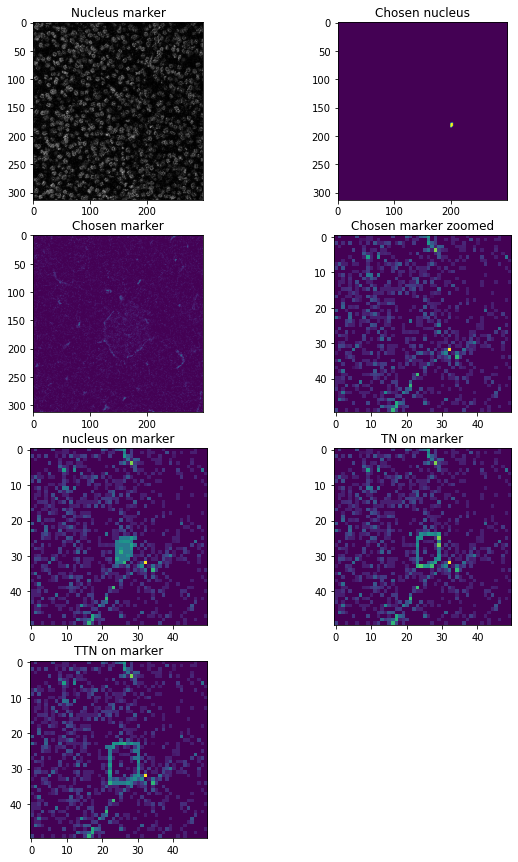

In [6]:
num = 7
imgNum = 5
binary = False
channel = 27
nucleusNum = 316
zoomSize  = 25

f = plt.figure(figsize=(10, 15))
axs = []
for i in range(num):
    axs.append(f.add_subplot(421 + i))

img = tifffile.imread(images[imgNum])
img = np.delete(img, (0,26,28,33,34,35,36), axis=0)
img = img[channel]
img = img / np.percentile(img, 99)
nuc = cv2.imread(nuclei[imgNum], -1)
mask = cv2.imread(masks[imgNum], -1)
mask[mask != nucleusNum] = 0
mask[mask != 0] = 2
# nuc = nuc.astype(mask.dtype)
# img = img.astype(mask.dtype)
mask = mask.astype(img.dtype)
nuc = nuc.astype(img.dtype)

if (binary):
    mask = mask > 0
c = 0
r = c
for row in range(len(mask)):
    for col in range(len(mask[row])):
        if mask[row][col] != 0:
            c = col
            r = row
            break
    if (c != 0):
        break

TN = np.zeros_like(mask)
TTN = np.zeros_like(mask)

for row in range(len(mask)):
    for col in range(len(mask[row])):
        if mask[row][col] == 0:
            if touchesNucleus(mask, row, col):
                    TN[row][col] = 2
                    
                    
for row in range(len(TN)):
    for col in range(len(TN[row])):
        if (TN[row][col] == 0) & (mask[row][col] == 0):
            if touchesNucleus(TN, row, col):
                    TTN[row][col] = 2
        
crop_rectangle = (c - zoomSize, r - zoomSize, c + zoomSize, r + zoomSize)
# cropped_im = im.crop(crop_rectangle)
both = cv2.addWeighted(img, 0.6, mask, 0.4, 0.0)
bothTN = cv2.addWeighted(img, 0.6, TN, 0.4, 0.0)
bothTTN = cv2.addWeighted(img, 0.6, TTN, 0.4, 0.0)

axs[0].imshow(nuc, cmap="Greys_r")
axs[0].title.set_text('Nucleus marker')
axs[1].imshow(mask)
axs[1].title.set_text('Chosen nucleus')
axs[2].imshow(img)
axs[2].title.set_text('Chosen marker')
axs[3].imshow(np.array(Image.fromarray(img).crop(crop_rectangle)))
axs[3].title.set_text('Chosen marker zoomed')
axs[4].imshow(np.array(Image.fromarray(both).crop(crop_rectangle)))
axs[4].title.set_text('nucleus on marker')
axs[5].imshow(np.array(Image.fromarray(bothTN).crop(crop_rectangle)))
axs[5].title.set_text('TN on marker')
axs[6].imshow(np.array(Image.fromarray(bothTTN).crop(crop_rectangle)))
axs[6].title.set_text('TTN on marker')

# Marker finding

In [47]:
nucleusNum = 160
imgNum = 10


Entire_img = tifffile.imread(images[imgNum])
Entire_img = np.delete(Entire_img, (0,26,28,33,34,35,36), axis=0)
dict_mean = {}
dict_median = {}
dict_25p = {}
dict_75p = {}

dict2_mean = {}
dict2_median = {}
dict2_25p = {}
dict2_75p = {}

for chan in range(len(Entire_img)):
    
    img = Entire_img[chan]
    img = img / np.percentile(img, 99)
    mask = cv2.imread(masks[imgNum], -1)
    mask[mask != nucleusNum] = 0


    TN = np.zeros_like(mask)
    TN_intens = []
    
    TTN = np.zeros_like(mask)
    TTN_intens = []

    for row in range(len(mask)):
        for col in range(len(mask[row])):
            if mask[row][col] == 0:
                if touchesNucleus(mask, row, col):
                        TN[row][col] = 2
                        TN_intens.append(img[row][col])
                        
    for row in range(len(TN)):
        for col in range(len(TN[row])):
            if (TN[row][col] == 0) & (mask[row][col] == 0):
                if touchesNucleus(TN, row, col):
                        TTN[row][col] = 2
                        TTN_intens.append(img[row][col])
    
    print('channel ' + str(chan) + ' score: ' + str(np.mean(TN_intens)))
    dict_mean[np.mean(TN_intens)] = chan
    dict_median[np.median(TN_intens)] = chan
    dict_75p[np.percentile(TN_intens, 75)] = chan
    dict_25p[np.percentile(TN_intens, 25)] = chan
    
    dict2_mean[np.mean(TTN_intens)] = chan
    dict2_median[np.median(TTN_intens)] = chan
    dict2_75p[np.percentile(TTN_intens, 75)] = chan
    dict2_25p[np.percentile(TTN_intens, 25)] = chan

channel 0 score: 0.11514521
channel 1 score: 0.12431834
channel 2 score: 0.07427009
channel 3 score: 0.087367624
channel 4 score: 0.47632784
channel 5 score: 0.42402208
channel 6 score: 0.14146584
channel 7 score: 0.030199578
channel 8 score: 0.1535784
channel 9 score: 0.054394733
channel 10 score: 0.0690077
channel 11 score: 0.10284211
channel 12 score: 0.45409408
channel 13 score: 0.07686842
channel 14 score: 0.078947365
channel 15 score: 0.1765814
channel 16 score: 0.09895376
channel 17 score: 0.49854636
channel 18 score: 0.057391018
channel 19 score: 0.06779311
channel 20 score: 0.10471675
channel 21 score: 0.24147011
channel 22 score: 0.0772293
channel 23 score: 0.05298643
channel 24 score: 0.1902797
channel 25 score: 0.28217542
channel 26 score: 0.14226006
channel 27 score: 0.1925112
channel 28 score: 0.24778256
channel 29 score: 0.47267285


In [48]:
dictArr = [dict_mean, dict_median, dict_25p, dict_75p, dict2_mean, dict2_median, dict2_25p, dict2_75p]
namesArr = ['mean', 'median', '25th percentile', '75th percentile', 'mean2', 'median2', '25th percentile2', '75th percentile2']
weightsArr = [.6, .2, .1, .1, .6, .2, .1, .1]

In [49]:
scores = {}
for chan in range(len(Entire_img)):
    scores[chan] = 0
for i in range(len(dictArr)):
    u = [*dictArr[i]]
    u.sort(reverse = True)
    dictArr[i][u[0]]
    print('Top 3 channels by ' + namesArr[i] + ' are: ' + str(dictArr[i][u[0]]) + ', '+
          str(dictArr[i][u[1]]) + ', '+ str(dictArr[i][u[2]]))
    for j in range(3):
        scores[dictArr[i][u[j]]] += (5 - j)*weightsArr[i]

Top 3 channels by mean are: 17, 4, 29
Top 3 channels by median are: 4, 5, 29
Top 3 channels by 25th percentile are: 17, 4, 29
Top 3 channels by 75th percentile are: 17, 29, 4
Top 3 channels by mean2 are: 21, 5, 17
Top 3 channels by median2 are: 12, 29, 5
Top 3 channels by 25th percentile2 are: 5, 12, 4
Top 3 channels by 75th percentile2 are: 5, 17, 29


In [50]:
scores
import operator
channels = sorted(scores, key=scores.get, reverse=True)[:3]
print(channels)
for i in range(len(channels)):
    print(scores[channels[i]])

[17, 5, 4]
6.2
4.800000000000001
4.3999999999999995


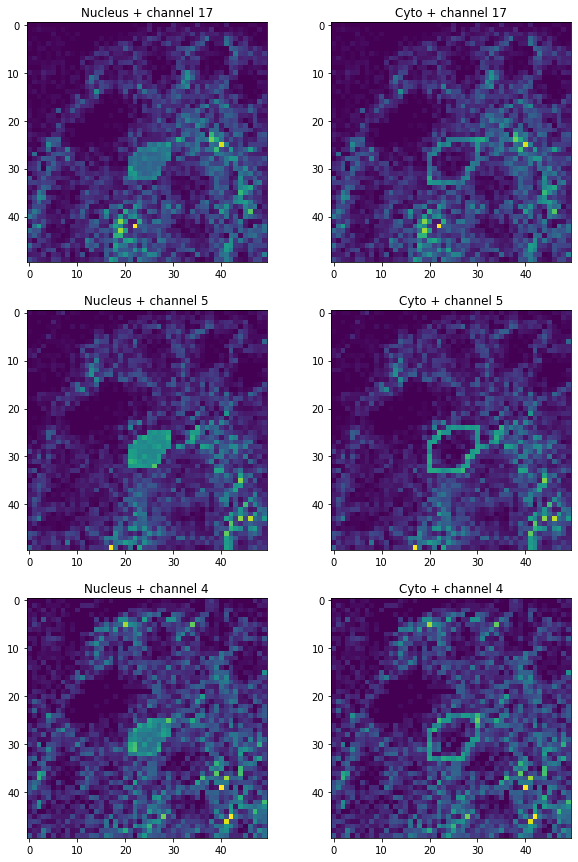

In [52]:
num = 6
zoomSize  = 25

f = plt.figure(figsize=(10, 15))
axs = []
for i in range(num):
    axs.append(f.add_subplot(321 + i))

img1 = Entire_img[channels[0]]
img1 = img1 / np.percentile(img1, 99)

img2 = Entire_img[channels[1]]
img2 = img2 / np.percentile(img1, 99)

img3 = Entire_img[channels[2]]
img3 = img3 / np.percentile(img2, 99)
mask = cv2.imread(masks[imgNum], -1)
mask[mask != nucleusNum] = 0
mask[mask != 0] = 2

mask = mask.astype(img.dtype)

if (binary):
    mask = mask > 0
c = 0
r = c
for row in range(len(mask)):
    for col in range(len(mask[row])):
        if mask[row][col] != 0:
            c = col
            r = row
            break
    if (c != 0):
        break

TN = np.zeros_like(mask)
TN_intens = []

for row in range(len(mask)):
    for col in range(len(mask[row])):
        if mask[row][col] == 0:
            i = 0
            if touchesNucleus(mask, row, col):
                    TN[row][col] = 2
        
crop_rectangle = (c - zoomSize, r - zoomSize, c + zoomSize, r + zoomSize)
# cropped_im = im.crop(crop_rectangle)
both1 = cv2.addWeighted(img1, 0.6, mask, 0.4, 0.0)
bothTN1 = cv2.addWeighted(img1, 0.6, TN, 0.4, 0.0)
both2 = cv2.addWeighted(img2, 0.06, mask, 0.94, 0.0)
bothTN2 = cv2.addWeighted(img2, 0.06, TN, 0.94, 0.0)
both3 = cv2.addWeighted(img3, 0.7, mask, 0.3, 0.0)
bothTN3 = cv2.addWeighted(img3, 0.7, TN, 0.3, 0.0)

axs[0].imshow(np.array(Image.fromarray(both1).crop(crop_rectangle)))
axs[0].title.set_text('Nucleus + channel ' + str(channels[0]))
axs[1].imshow(np.array(Image.fromarray(bothTN1).crop(crop_rectangle)))
axs[1].title.set_text('Cyto + channel ' + str(channels[0]))
axs[2].imshow(np.array(Image.fromarray(both2).crop(crop_rectangle)))
axs[2].title.set_text('Nucleus + channel ' + str(channels[1]))
axs[3].imshow(np.array(Image.fromarray(bothTN2).crop(crop_rectangle)))
axs[3].title.set_text('Cyto + channel ' + str(channels[1]))
axs[4].imshow(np.array(Image.fromarray(both3).crop(crop_rectangle)))
axs[4].title.set_text('Nucleus + channel ' + str(channels[2]))
axs[5].imshow(np.array(Image.fromarray(bothTN3).crop(crop_rectangle)))
axs[5].title.set_text('Cyto + channel ' + str(channels[2]))

In [5]:
def touchesNucleus(mask, row, col):
    
    if (row < len(mask) - 1):
        if (mask[row + 1][col] != 0):
            return True
    if (row > 0):
        if (mask[row - 1][col] != 0):
            return True
    if (col < len(mask[row]) - 1):
        if (mask[row][col + 1] != 0):
            return True
    if (col > 0):
        if (mask[row][col - 1] != 0):
            return True
    if (row < len(mask) - 1) and (col < len(mask[row]) - 1):
        if (mask[row + 1][col + 1] != 0):
            return True
    if (row < len(mask) - 1) and (col > 0):
        if (mask[row + 1][col - 1] != 0):
            return True
    if (row > 0) and (col < len(mask[row]) - 1):
        if (mask[row - 1][col + 1] != 0):
            return True
    if (row > 0) and (col > 0):
        if (mask[row - 1][col - 1] != 0):
            return True